# The Rhinovirus infection dataset

https://datadryad.org/stash/dataset/doi:10.5061/dryad.4xgxd25g1

In [1]:
import scanpy as sc
adata=sc.read_h5ad("../data/rvcse_221021.h5ad")
print(adata)

AnnData object with n_obs × n_vars = 26420 × 3608
    obs: 'batch', 'leiden', 'cell_type1021'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'batch_colors', 'cell_type1021_colors', 'cell_type1021_sizes', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'paga', 'pca', 'rank_genes_groups', 'tsne', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'


/home/xx244/.conda/envs/benchmark/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [2]:
import numpy as np
print(np.unique(adata.obs['cell_type1021']))
print(np.unique(adata.obs['batch']))

['Basal' 'Brush+PNEC' 'Ciliated' 'Cycling basal' 'Doublet' 'Hillock'
 'Ionocyte' 'Myoepithelial' 'Pre-ciliated' 'Secretory']
['CSE' 'MOCK' 'RV' 'RVCSE']


In [3]:
adata=adata[adata.obs["batch"].isin(['CSE',"MOCK"])].copy()
adata.obs["perturbation"]=adata.obs["batch"].copy()
print(np.unique(adata.obs["perturbation"],return_counts=True))
print(adata)
print(adata.X[:10,:10])
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata,ncols=1,color=["batch","cell_type1021"])

/home/xx244/.conda/envs/benchmark/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


(array(['CSE', 'MOCK'], dtype=object), array([7087, 5168]))
AnnData object with n_obs × n_vars = 12255 × 3608
    obs: 'batch', 'leiden', 'cell_type1021', 'perturbation'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'batch_colors', 'cell_type1021_colors', 'cell_type1021_sizes', 'hvg', 'leiden', 'log1p', 'neighbors', 'paga', 'pca', 'rank_genes_groups', 'tsne', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'
[[-0.13127026 -0.6043305  -0.42346737 -0.5286249  -0.585026   -0.40917814
  -0.5307799  -0.34020615 -0.17789422 -0.20318672]
 [-0.13127026 -0.6043305  -0.42346737 -0.5286249  -0.585026    0.5870511
   0.23046492  0.8015358  -0.17789422 -0.20318672]
 [-0.13127026  0.10818027 -0.42346737  0.7196166  -0.585026   -0.40917814
  -0.5307799   1.6135037  -0.17789422 -0.20318672]
 [-0.13127026 -0.6043305  -0.42346737 -0.5286249   3.4485416  -0.40917814
  -0.5307799  -0.34020615 -0.17789422 -0

KeyboardInterrupt: 

In [4]:
from ndreamer import NDreamer
model = NDreamer(adata, condition_key="perturbation", contorl_name='MOCK', num_hvg=3608, require_batch=False,
                            batch_key=None,
                            resolution_low=0.5, resolution_high=7, cluster_method="Leiden", embedding_dim=512,
                            codebooks=[1024 for i in range(32)],
                            codebook_dim=8, encoder_hidden=[1024, 512], decoder_hidden=[512, 1024], z_dim=256,
                            cos_loss_scaler=20, random_seed=123, batch_size=1024, epoches=100, lr=1e-3,
                            triplet_margin=5,independent_loss_scaler=1000, save_pth="./virus/",
                            developer_test_mode=False,
                            library_size_normalize_adata=False,
                            save_preprocessed_adata_path="./virus/preprocessed.h5ad",
                            KL_scaler=5e-3, reconstruct_scaler=1, triplet_scaler=5, num_triplets_per_label=15,
                            tau=0.01, commitment_loss_scaler=1, cluster_correlation_scaler=50,reset_threshold=1/1024,
                            reset_interval=30,try_identify_cb_specific_subtypes=False,
                            local_neighborhood_loss_scaler=1,local_neighbor_sigma=1,
                            try_identify_perturb_escaped_cell=False,n_neighbors=20,
                            local_neighbor_across_cluster_scaler=20, have_negative_data=True)

model.train_model()
model.get_modifier_space()

model.decompose_true_expression_batch_effect_all(nearest_neighbor=1,bandwidth=1)
model.Estmiate_ITE_all(nearest_neighbor=1,bandwidth=1)

Start data preprocessing
Indices are not unique. Adding condition information to adata.obs_names


KeyError: 'group'

In [5]:
adata1=model.DL_model.adata.copy()

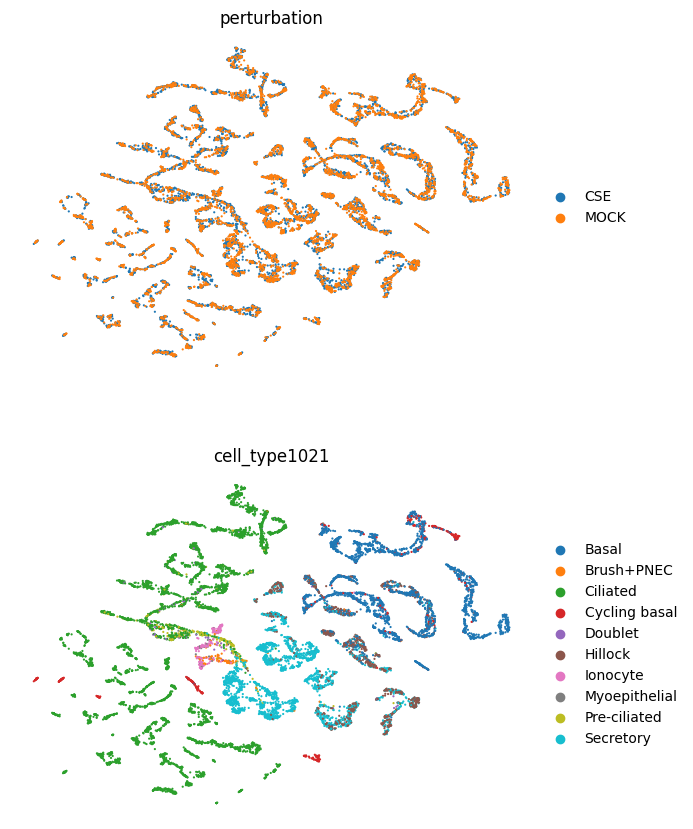

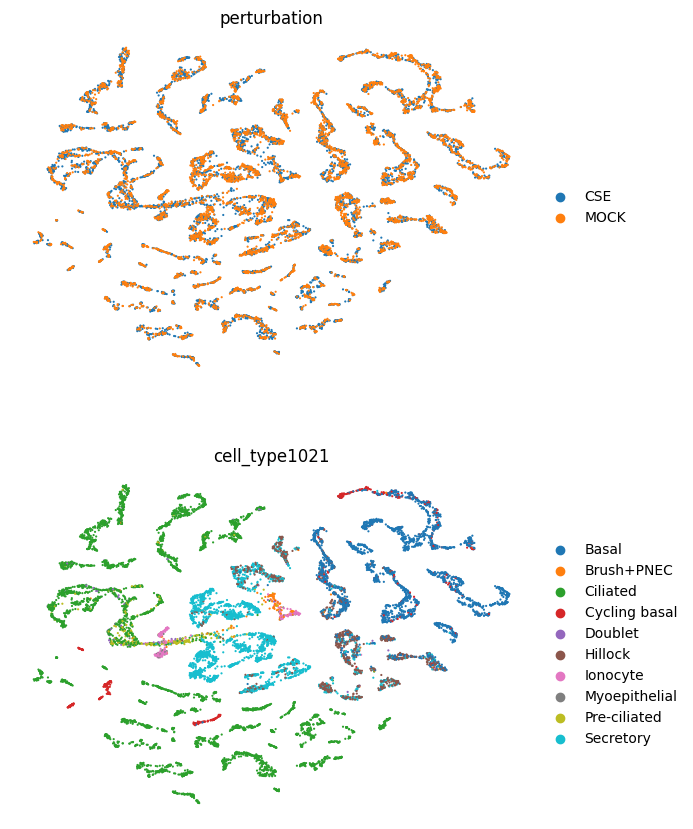

In [6]:
sc.pp.neighbors(adata1, use_rep='X_effect_modifier_space_PCA', n_neighbors=25)
sc.tl.umap(adata1)
sc.pl.umap(adata1, color=['perturbation', 'cell_type1021'], frameon=False, ncols=1)

sc.pp.neighbors(adata1, use_rep='X_effect_modifier_space', n_neighbors=25)
sc.tl.umap(adata1)
sc.pl.umap(adata1, color=['perturbation', 'cell_type1021'], frameon=False, ncols=1)

In [7]:
import rpy2.robjects as robjects
import os
os.environ["R_HOME"]="/home/xx244/.conda/envs/benchmark/lib/R"
import anndata2ri
anndata2ri.activate()
from metrics import calculate_metrics

try:
    calculate_metrics(adata1, batch_key='condition', celltype_key='cell_type1021', all=True, n_neighbors=25, embed='X_effect_modifier_space_PCA')
except:
    calculate_metrics(adata1, batch_key='condition', celltype_key='cell_type1021', all=True, n_neighbors=25, embed='X_effect_modifier_space_PCA')

Unable to determine R library path: Command '('/vast/palmer/apps/avx2/software/R/4.3.2-foss-2022b-patched/lib64/R/bin/Rscript', '-e', 'cat(Sys.getenv("LD_LIBRARY_PATH"))')' returned non-zero exit status 127.
/tmp/ipykernel_58868/2192594016.py:5: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


R_HOME is already set to: /home/xx244/.conda/envs/benchmark/lib/R


/gpfs/gibbs/project/wang_zuoheng/xx244/Ndreamer/reproducible/metrics.py:29: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/home/xx244/.conda/envs/benchmark/lib/python3.11/site-packages/rpy2/robjects/pandas2ri.py:368: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/xx244/.conda/envs/benchmark/lib/python3.11/site-packages/rpy2/robjects/numpy2ri.py:241: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '


LISI---
cLISI, bLISI, LISI_F1 0.9664824631798726 0.7514666186272224 0.845519015970277
ASW---
asw_label 0.7011679708957672
asw_batch 0.8040135095878405
kBET---
0 labels consist of a single batch or is too small. Skip.
Adding diffusion to step 4
Adding diffusion to step 5
Adding diffusion to step 6
Adding diffusion to step 4
Adding diffusion to step 4
Adding diffusion to step 5
Adding diffusion to step 6
Adding diffusion to step 7
Adding diffusion to step 8
Adding diffusion to step 4
Adding diffusion to step 5
Adding diffusion to step 6
Adding diffusion to step 7
Adding diffusion to step 8
Adding diffusion to step 9
Adding diffusion to step 10
Adding diffusion to step 11
Adding diffusion to step 12
Adding diffusion to step 4
Adding diffusion to step 4
Adding diffusion to step 5
Adding diffusion to step 6
Adding diffusion to step 7
Adding diffusion to step 8
Adding diffusion to step 4
Adding diffusion to step 5
Adding diffusion to step 6
kbet_score 0.5364813267529234
graph_conn 0.67846842